In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import os

In [2]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

Using TensorFlow backend.


In [3]:
DATA_DIR = os.path.join(os.getcwd(), '../data/safety/kfengtee.csv')

agg_diff_df = pd.read_csv(DATA_DIR)
agg_diff_df = agg_diff_df.drop('bookingid', axis='columns')
agg_diff_df.head(n=10)

,acceleration_mean,acceleration_median,acceleration_std,acceleration_spread,gyro_pc_mean,gyro_pc_median,gyro_pc_std,gyro_pc_spread,speed_mean,speed_median,...,second_spread,over_speed,over_second,over_acceleration_x,over_acceleration_y,over_acceleration_z,over_gyro_x,over_gyro_y,over_gyro_z,label
0,9.883337,9.852269,0.619492,6.530989,-0.006583,-0.002863,0.099002,1.101352,9.003204,8.503366,...,1589.0,247,687,709,1002,801,570,581,614,0
1,9.865608,9.847932,0.522142,5.819621,-0.006855,-0.003612,0.090770,1.123587,8.019369,7.206634,...,1034.0,157,168,483,270,790,230,404,347,1
2,9.929590,9.877755,0.515173,5.168422,-0.012751,0.001369,0.117109,0.896289,3.157213,2.998761,...,825.0,0,0,102,143,34,67,103,71,1
3,9.813434,9.791035,0.620066,13.349284,0.022429,0.024239,0.112628,1.166471,6.150996,3.310000,...,1094.0,122,232,389,1094,1072,531,735,753,1
4,9.918090,9.904142,0.585346,7.280114,0.000480,0.004189,0.106469,1.161481,4.628921,1.936962,...,1094.0,18,232,463,407,257,533,450,561,0
5,9.826470,9.789800,0.916836,8.572037,0.002651,-0.002687,0.072664,0.903745,12.176386,13.017325,...,959.0,365,97,809,262,219,561,490,687,0
6,9.763213,9.646309,0.730155,9.416841,-0.000840,0.000250,0.078446,0.754180,5.384260,3.540000,...,462.0,25,0,357,94,36,157,159,82,0
7,9.550677,9.494390,0.833292,9.474737,0.001922,-0.000612,0.110181,0.909695,8.702027,9.580000,...,374.0,90,0,300,71,307,90,111,149,0
8,9.948639,9.877962,0.750480,5.686104,-0.004018,-0.003111,0.151980,0.988519,6.659024,5.192059,...,299.0,14,0,129,120,44,147,154,141,0
9,9.873517,9.823053,0.425662,5.916028,-0.002192,0.000388,0.082987,0.767631,4.152211,3.702154,...,555.0,1,0,155,441,10,349,207,374,0


In [4]:
from sklearn.preprocessing import StandardScaler

seed = 199

np.random.seed(seed)

count_0 = agg_diff_df['label'].value_counts()[0]
count_1 = agg_diff_df['label'].value_counts()[1]

idx0 = agg_diff_df[agg_diff_df['label'] == 0].index.values
sample_0_idx = np.random.choice(idx0, count_1)

df_0 = agg_diff_df.iloc[sample_0_idx, :]
downsample_df = pd.concat([df_0, agg_diff_df[agg_diff_df['label'] == 1]]).sample(frac=1).reset_index(drop=True)

X = downsample_df.drop('label', axis=1)
y = downsample_df['label']

X_train, X_test2, y_train, y_test2 = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)

In [6]:
prop = count_1 / (count_0 + count_1)
sample_0_idx2 = [idx for idx in idx0 if idx not in sample_0_idx]

y_count = y_test2.value_counts()[1]
sample_0_idx2 = np.random.choice(sample_0_idx2, size=np.int((y_count / 20) * 100))

new_df0 = agg_diff_df.iloc[sample_0_idx, :].sample(n=np.int((y_count / 20) * 100))
test = pd.merge(X_test2, y_test2, left_index=True, right_index=True)
test = test[test['label'] == 1]

df_merge = pd.concat([new_df0, test], axis=0).reset_index(drop=True).sample(frac=1)

X_test, y_test = df_merge.drop('label', axis=1), df_merge['label']

In [7]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
# X_train_scaled.describe()

X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
# X_test_scaled.describe()

In [8]:
def build_model():
    model = Sequential([
        Dense(64, activation="relu", input_shape=((24,))),
        Dropout(rate=0.5),
        Dense(64, activation="relu"),
        Dropout(rate=0.5),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", 
               optimizer=optimizers.SGD(lr=0.001),
               metrics=["accuracy"])
    
    return model


import datetime
start_time = datetime.datetime.now()

k = 10
num_val_samples = X_train_scaled.shape[0] // k
num_epochs = 60
batch_size = 8
all_val_loss = []
all_train_loss = []
all_val_acc = []
all_train_acc = []

for i in range(k):
    print('Processing fold {} of {}'.format(i + 1, k))

    val_data = X_train_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([X_train_scaled[:i * num_val_samples], 
                                         X_train_scaled[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], 
                                            y_train[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, verbose=0,
                        validation_data=((val_data, val_targets)))

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    all_val_loss.append(val_loss)
    all_train_loss.append(loss)
    all_val_acc.append(val_acc)
    all_train_acc.append(acc)

    end_time = datetime.datetime.now()
    print("Total time taken: {} seconds".format((end_time - start_time).seconds))

Processing fold 1 of 10
Total time taken: 59 seconds
Processing fold 2 of 10
Total time taken: 118 seconds
Processing fold 3 of 10
Total time taken: 178 seconds
Processing fold 4 of 10
Total time taken: 239 seconds
Processing fold 5 of 10
Total time taken: 302 seconds
Processing fold 6 of 10
Total time taken: 365 seconds
Processing fold 7 of 10
Total time taken: 427 seconds
Processing fold 8 of 10
Total time taken: 490 seconds
Processing fold 9 of 10
Total time taken: 558 seconds
Processing fold 10 of 10
Total time taken: 620 seconds


Train loss: 0.6420859968538851, train acc: 0.6243284940719604
Val loss: 0.6204740137987834, val acc: 0.6440805792808533


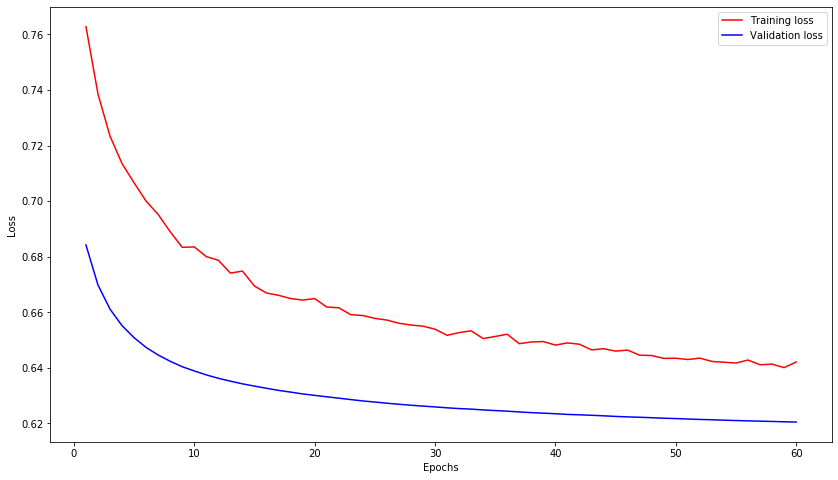

In [9]:
average_val_loss = [np.mean([x[i] for x in all_val_loss]) for i in range(num_epochs)]
average_train_loss = [np.mean([x[i] for x in all_train_loss]) for i in range(num_epochs)]

average_val_acc = [np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]
average_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(num_epochs)]

print("Train loss: {}, train acc: {}".format(average_train_loss[-1], average_train_acc[-1]))
print("Val loss: {}, val acc: {}".format(average_val_loss[-1], average_val_acc[-1]))

plt.figure(figsize=(14,8))
plt.plot(range(1, len(average_train_loss) + 1), average_train_loss, color="r", label="Training loss")
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss, color="b", label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import classification_report

res = model.predict(X_test_scaled)
res = [round(num[0]) for num in res]

roc_auc_score(y_test, res)

0.6374871266735325